# REGRESSION ANALYSIS

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import scale

In [3]:
# Printin the version of the libraries used so that the replication of the notebook can be done easily
print(f"Numpy version : Numpy {np.__version__}")
print(f"Statsmodel version : Statsmodels {statsmodels.__version__}")
print(f"Pandas version : Pandas {pd.__version__}")
print(f"Matplotlib version : Matplotlib {matplotlib.__version__}")
print(f"Seaborn version : Seaborn {sns.__version__}")

Numpy version : Numpy 1.21.5
Statsmodel version : Statsmodels 0.13.2
Pandas version : Pandas 1.4.1
Matplotlib version : Matplotlib 3.5.1
Seaborn version : Seaborn 0.11.2


In [4]:
# Setting the pandas to display the maximum column avaliable
pd.set_option('display.max_columns', None)
# Setting the style to the plot which will be plotted using Seaborn
sns.set_style("darkgrid")

In [5]:
data = pd.read_csv('train.csv', encoding='latin')

## DATA PREPROCESSING 

In [6]:
def detailed(data, threshold = 1):
    '''
    input:
        data: the data for which we need to find the details and it should be in df form
        threshold: the maximum premissble missing value in an column
        
    returns:
            detailed_data, to_drop, imbalance_cols
            the complete EDA of the dataset provided, and list of columns who have all values nan
    
    '''
    ddata = pd.DataFrame(index=['total', '% missing' , 'data Type', 'range'])
    to_drop = []
    imbalance_cols = []
    for cols in data.columns:
        size = data[cols].size
        # Finding the number of null present in the column         
        pnul=round(data[cols].isna().sum()/size,2)
        nul_val = f"{pnul*100}% - {data[cols].isna().sum()}/{size}"
        if data[cols].isna().sum() == size:
            to_drop.append(cols)
        elif data[cols].isna().sum() >= int(size*threshold):
            to_drop.append(cols)
        # finding the Varibale type of the column
        dtype = 'categorical' if data[cols].dtype == object else 'Numerical' 
        # Findig the range of the Data if numerical else finding the count of different labels        
        rng = f"{len(data[cols].unique())} labels"\
        if dtype == 'categorical' else\
        f"{round(data[cols].min(),2)}-{round(data[cols].max(),2)}"
        # Finding the most repeating value         
#         max_value = data[cols].value_counts().index[0]
        max_count = data[cols].value_counts().max()
        # if there is same value all acroos the dataframe then we should drop it as it will cause baising
        if max_count> int(size*0.85):
            imbalance_cols.append(cols)
        ddata[cols] = [size,nul_val,dtype,rng]
    return ddata, to_drop, imbalance_cols

In [7]:
det,to_drop, imbalance_cols = detailed(data, threshold=0.9)

In [8]:
det

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
total,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
% missing,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,18.0% - 259/1460,0.0% - 0/1460,0.0% - 0/1460,94.0% - 1369/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,1.0% - 8/1460,1.0% - 8/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,3.0% - 37/1460,3.0% - 37/1460,3.0% - 38/1460,3.0% - 37/1460,0.0% - 0/1460,3.0% - 38/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 1/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,47.0% - 690/1460,6.0% - 81/1460,6.0% - 81/1460,6.0% - 81/1460,0.0% - 0/1460,0.0% - 0/1460,6.0% - 81/1460,6.0% - 81/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,100.0% - 1453/1460,81.0% - 1179/1460,96.0% - 1406/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460,0.0% - 0/1460
data Type,Numerical,Numerical,categorical,Numerical,Numerical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,Numerical,Numerical,Numerical,Numerical,categorical,categorical,categorical,categorical,categorical,Numerical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,Numerical,categorical,Numerical,Numerical,Numerical,categorical,categorical,categorical,categorical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,categorical,Numerical,categorical,Numerical,categorical,categorical,Numerical,categorical,Numerical,Numerical,categorical,categorical,categorical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,categorical,categorical,categorical,Numerical,Numerical,Numerical,categorical,categorical,Numerical
range,1-1460,20-190,5 labels,21.0-313.0,1300-215245,2 labels,3 labels,4 labels,4 labels,2 labels,5 labels,3 labels,25 labels,9 labels,8 labels,5 labels,8 labels,1-10,1-9,1872-2010,1950-2010,6 labels,8 labels,15 labels,16 labels,5 labels,0.0-1600.0,4 labels,5 labels,6 labels,5 labels,5 labels,5 labels,7 labels,0-5644,7 labels,0-1474,0-2336,0-6110,6 labels,5 labels,2 labels,6 labels,334-4692,0-2065,0-572,334-5642,0-3,0-2,0-3,0-2,0-8,0-3,4 labels,2-14,7 labels,0-3,6 labels,7 labels,1900.0-2010.0,4 labels,0-4,0-1418,6 labels,6 labels,3 labels,0-857,0-547,0-552,0-508,0-480,0-738,4 labels,5 labels,5 labels,0-15500,1-12,2006-2010,9 labels,6 labels,3

In [9]:
print(to_drop);print(imbalance_cols)

['Alley', 'PoolQC', 'MiscFeature']
['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'BsmtFinSF2', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SaleType']


In [10]:
# Lets drop the columns which have more than 70% of data missing
data.drop(to_drop, axis=1, inplace=True)

In [11]:
# All data with Nan vlaues
round(data.isna().sum()/len(data),3).sort_values(ascending=False).head(20)

Fence           0.808
FireplaceQu     0.473
LotFrontage     0.177
GarageYrBlt     0.055
GarageType      0.055
GarageFinish    0.055
GarageQual      0.055
GarageCond      0.055
BsmtExposure    0.026
BsmtFinType2    0.026
BsmtQual        0.025
BsmtCond        0.025
BsmtFinType1    0.025
MasVnrType      0.005
MasVnrArea      0.005
Electrical      0.001
Fireplaces      0.000
KitchenQual     0.000
KitchenAbvGr    0.000
BedroomAbvGr    0.000
dtype: float64

In [12]:
# Categorical data with nan values
round(data.select_dtypes(include='object').isnull().sum()[data.select_dtypes(include='object').isnull().sum()>0]/len(data),3)

MasVnrType      0.005
BsmtQual        0.025
BsmtCond        0.025
BsmtExposure    0.026
BsmtFinType1    0.025
BsmtFinType2    0.026
Electrical      0.001
FireplaceQu     0.473
GarageType      0.055
GarageFinish    0.055
GarageQual      0.055
GarageCond      0.055
Fence           0.808
dtype: float64

#### Treating NaN values

In [13]:
# These are the cols which have nan values and are categorical in nature
nan_cols_cats = ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Electrical']

In [14]:
data[nan_cols_cats]=data[nan_cols_cats].fillna('None')

In [15]:
data[nan_cols_cats].head()

,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,Fence,Electrical
0,BrkFace,Gd,TA,No,GLQ,Unf,None,Attchd,RFn,TA,TA,None,SBrkr
1,None,Gd,TA,Gd,ALQ,Unf,TA,Attchd,RFn,TA,TA,None,SBrkr
2,BrkFace,Gd,TA,Mn,GLQ,Unf,TA,Attchd,RFn,TA,TA,None,SBrkr
3,None,TA,Gd,No,ALQ,Unf,Gd,Detchd,Unf,TA,TA,None,SBrkr
4,BrkFace,Gd,TA,Av,GLQ,Unf,TA,Attchd,RFn,TA,TA,None,SBrkr


In [16]:
# Finding the columns which have repearing values
_,_,imbalance_cols = detailed(data,0.9)

In [17]:
# Selecting only those columns which are categorical in nature
rep_cols = data[imbalance_cols].select_dtypes(include='object').columns

In [18]:
# Dropping the repearing values cols which are categorical in nature
data.drop(rep_cols, axis=1, inplace=True)

#### Treating Numerical NaN values 

In [19]:
data.select_dtypes(include=['int64','float']).isnull().sum()[data.select_dtypes(include=['int64','float']).isnull().sum()>0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [20]:
data.LotFrontage.fillna(data.LotFrontage.median(), inplace=True)

In [21]:
data.MasVnrArea.fillna(data.MasVnrArea.median(), inplace=True)

In [22]:
data.GarageYrBlt.fillna(0, inplace=True)

In [23]:
data.GarageYrBlt=data.GarageYrBlt.astype(int)

In [24]:
# We will create a derived column which will help us captur more information from the GarageYrBlt column
def process_garage(row):
    
    if row == 0 or (row>=1900 and row<2000):
        return 0 
    return 1

In [25]:
data['NeworOldGarage'] = data.GarageYrBlt.apply(process_garage)

In [26]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,NeworOldGarage
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,0,None,Attchd,2003,RFn,2,548,0,61,0,0,0,0,None,0,2,2008,Normal,208500,1
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,1,TA,Attchd,1976,RFn,2,460,298,0,0,0,0,0,None,0,5,2007,Normal,181500,0
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,1,TA,Attchd,2001,RFn,2,608,0,42,0,0,0,0,None,0,9,2008,Normal,223500,1
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,1,Gd,Detchd,1998,Unf,3,642,0,35,272,0,0,0,None,0,2,2006,Abnorml,140000,0
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,1,TA,Attchd,2000,RFn,3,836,192,84,0,0,0,0,None,0,12,2008,Normal,250000,1


In [27]:
# we will create a derived column Remodelled which will tell us if the house is remodelled or not
def remodelled_check(row):
    if row['YearBuilt'] == row['YearRemodAdd']:
        return 0
    elif row['YearBuilt']<row['YearRemodAdd']:
        return 1
    else:
        return 2
    

In [28]:
data['Remodelled'] = data.apply(remodelled_check, axis=1)

In [29]:
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,NeworOldGarage,Remodelled
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,0,None,Attchd,2003,RFn,2,548,0,61,0,0,0,0,None,0,2,2008,Normal,208500,1,0
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,1,TA,Attchd,1976,RFn,2,460,298,0,0,0,0,0,None,0,5,2007,Normal,181500,0,0
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,1,TA,Attchd,2001,RFn,2,608,0,42,0,0,0,0,None,0,9,2008,Normal,223500,1,1
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,1,Gd,Detchd,1998,Unf,3,642,0,35,272,0,0,0,None,0,2,2006,Abnorml,140000,0,1
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,1,TA,Attchd,2000,RFn,3,836,192,84,0,0,0,0,None,0,12,2008,Normal,250000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Reg,Inside,Gilbert,1Fam,2Story,6,5,1999,2000,Gable,VinylSd,VinylSd,None,0.0,TA,PConc,Gd,No,Unf,0,0,953,953,Ex,953,694,0,1647,0,0,2,1,3,1,TA,7,1,TA,Attchd,1999,RFn,2,460,0,40,0,0,0,0,None,0,8,2007,Normal,175000,0,1
1456,1457,20,RL,85.0,13175,Reg,Inside,NWAmes,1Fam,1Story,6,6,1978,1988,Gable,Plywood,Plywood,Stone,119.0,TA,CBlock,Gd,No,ALQ,790,163,589,1542,TA,2073,0,0,2073,1,0,2,0,3,1,TA,7,2,TA,Attchd,1978,Unf,2,500,349,0,0,0,0,0,MnPrv,0,2,2010,Normal,210000,0,1
1457,1458,70,RL,66.0,9042,Reg,Inside,Crawfor,1Fam,2Story,7,9,1941,2006,Gable,CemntBd,CmentBd,None,0.0,Ex,Stone,TA,No,GLQ,275,0,877,1152,Ex,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,2,Gd,Attchd,1941,RFn,1,252,0,60,0,0,0,0,GdPrv,2500,5,2010,Normal,266500,0,1
1458,1459,20,RL,68.0,9717,Reg,Inside,NAmes,1Fam,1Story,5,6,1950,1996,Hip,MetalSd,MetalSd,None,0.0,TA,CBlock,TA,Mn,GLQ,49,1029,0,1078,Gd,1078,0,0,1078,1,0,1,0,2,1,Gd,5,0,None,Attchd,1950,Unf,1,240,366,0,112,0,0,0,None,0,4,2010,Normal,142125,0,1


In [30]:
#  We will derive the column BuiltRemodelAge to find the age 
def getAge(row):

    if(row['YearBuilt'] == row['YearRemodAdd']):
        return row['YrSold'] - row['YearBuilt']
    else:
        return row['YrSold'] - row['YearRemodAdd']
    

In [31]:
data['BuiltRemodelAge']=data.apply(getAge, axis=1)

In [32]:
data = data[data['BuiltRemodelAge']>=0]

#### I have create derived columns so I will be dropping them to reduce multi-colinearity 

In [33]:
data.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], axis = 1, inplace=True)

C:\Users\samee\AppData\Local\Temp\ipykernel_5564\2552553597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], axis = 1, inplace=True)


#### Now we will Check the Numerical Values which have more than 85% similar values 

In [34]:
_,_,imb = detailed(data)

In [35]:
# we can see that all these coulms are of numerical type and have 85% simialr data so to reduce skewness we will drop them also we will drop MoSold
data[imb].select_dtypes(include=['float','int64'])

,BsmtFinSF2,LowQualFinSF,BsmtHalfBath,KitchenAbvGr,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,0,0,0,1,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,1,272,0,0,0,0
4,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1455,0,0,0,1,0,0,0,0,0
1456,163,0,0,1,0,0,0,0,0
1457,0,0,0,1,0,0,0,0,2500
1458,1029,0,0,1,112,0,0,0,0


#### we will be dropping the 85% repeating values and MoSold 

In [36]:
data.drop(imb, axis=1,inplace=True)

C:\Users\samee\AppData\Local\Temp\ipykernel_5564\1231064928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(imb, axis=1,inplace=True)


In [37]:
data.drop(['MoSold'], axis=1, inplace=True)

C:\Users\samee\AppData\Local\Temp\ipykernel_5564\155470306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['MoSold'], axis=1, inplace=True)


### Checking for missing valus in the dataframe 

In [38]:
data.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage        0
LotArea            0
LotShape           0
LotConfig          0
Neighborhood       0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
RoofStyle          0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
ExterQual          0
Foundation         0
BsmtQual           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         0
BsmtUnfSF          0
TotalBsmtSF        0
HeatingQC          0
1stFlrSF           0
2ndFlrSF           0
GrLivArea          0
BsmtFullBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenQual        0
TotRmsAbvGrd       0
Fireplaces         0
FireplaceQu        0
GarageType         0
GarageFinish       0
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
Fence              0
SaleCondition      0
SalePrice          0
NeworOldGarage     0
Remodelled   

### Checking for duplicated values in the dataframe 

In [39]:
data[data.duplicated()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,Fence,SaleCondition,SalePrice,NeworOldGarage,Remodelled,BuiltRemodelAge


### Checking for outliers Outliers

In [40]:
data.describe(percentiles=[.25,.5,.75,.95,.99])

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,NeworOldGarage,Remodelled,BuiltRemodelAge
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,730.641535,56.895134,69.822481,10496.555860,6.096642,5.575737,102.665524,442.394791,567.027416,1056.003427,1161.272790,346.176148,1513.297464,0.424949,1.564085,0.382454,2.866347,6.514736,0.612748,1.766278,472.698424,94.166552,46.413982,180918.571624,0.274846,0.476354,22.966415
std,421.719871,42.314997,21.978837,9954.574954,1.379691,1.113079,179.967423,453.766233,441.943479,435.457633,383.241975,435.561934,519.098418,0.518870,0.549821,0.502798,0.816050,1.621705,0.644808,0.746873,213.606916,125.346347,65.606770,79469.678565,0.446590,0.499612,20.638195
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,0.000000,0.000000,0.000000
25%,365.500000,20.000000,60.000000,7549.000000,5.000000,5.000000,0.000000,0.000000,223.000000,795.500000,882.000000,0.000000,1129.000000,0.000000,1.000000,0.000000,2.000000,5.000000,0.000000,1.000000,333.000000,0.000000,0.000000,129950.000000,0.000000,0.000000,4.000000
50%,731.000000,50.000000,69.000000,9477.000000,6.000000,5.000000,0.000000,383.000000,476.000000,991.000000,1086.000000,0.000000,1464.000000,0.000000,2.000000,0.000000,3.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,163000.000000,0.000000,0.000000,14.000000
75%,1095.500000,70.000000,79.000000,11600.000000,7.000000,6.000000,164.000000,712.000000,808.000000,1297.500000,1391.000000,728.000000,1776.000000,1.000000,2.000000,1.000000,3.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,214000.000000,1.000000,1.000000,41.000000
95%,1387.100000,160.000000,104.000000,17235.300000,8.000000,8.000000,452.400000,1270.400000,1468.000000,1752.100000,1828.300000,1140.100000,2462.400000,1.000000,2.000000,1.000000,4.000000,10.000000,2.000000,3.000000,846.400000,335.000000,174.100000,326200.000000,1.000000,1.000000,58.000000
99%,1445.420000,190.000000,137.420000,36070.800000,10.000000,9.000000,791.360000,1569.100000,1797.100000,2143.140000,2211.200000,1401.240000,3096.920000,2.000000,3.000000,1.000000,5.000000,11.000000,2.000000,3.000000,1002.980000,505.520000,283.260000,442629.620000,1.000000,1.000000,60.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,2336.000000,6110.000000,4692.000000,2065.000000,5642.000000,3.000000,3.000000,2.000000,8.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,755000.000000,1.000000,1.000000,60.000000


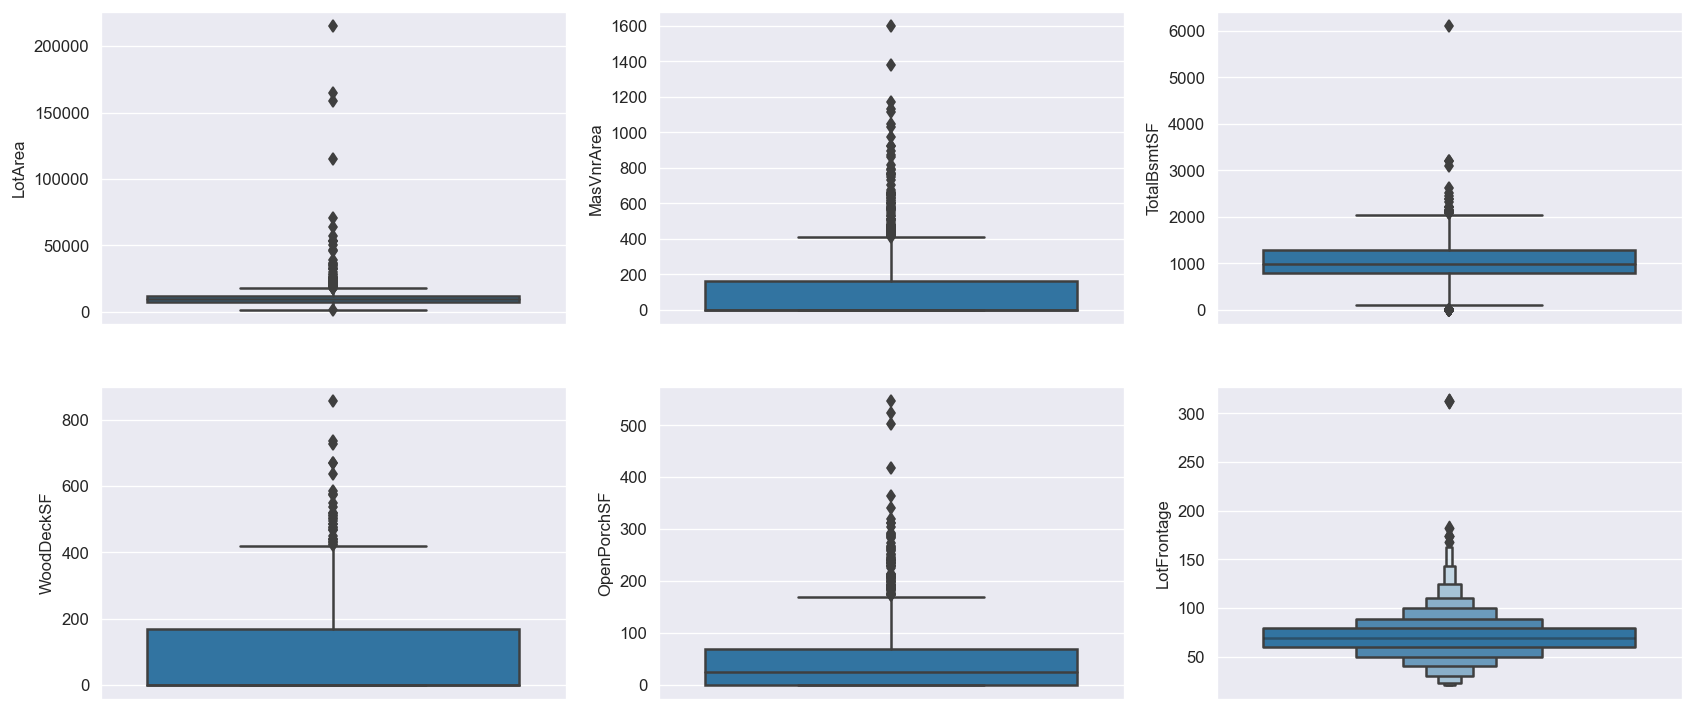

In [41]:
plt.figure(figsize=(17, 20), dpi=120)
plt.subplot(5,3,1)
sns.boxplot(y = 'LotArea', data=data )
plt.subplot(5,3,2)
sns.boxplot(y = 'MasVnrArea', data=data )
plt.subplot(5,3,3)
sns.boxplot(y = 'TotalBsmtSF', data=data)
plt.subplot(5,3,4)
sns.boxplot(y = 'WoodDeckSF', data=data )
plt.subplot(5,3,5)
sns.boxplot(y = 'OpenPorchSF', data=data)
plt.subplot(5,3,6)
sns.boxenplot(y='LotFrontage', data=data)
plt.show()

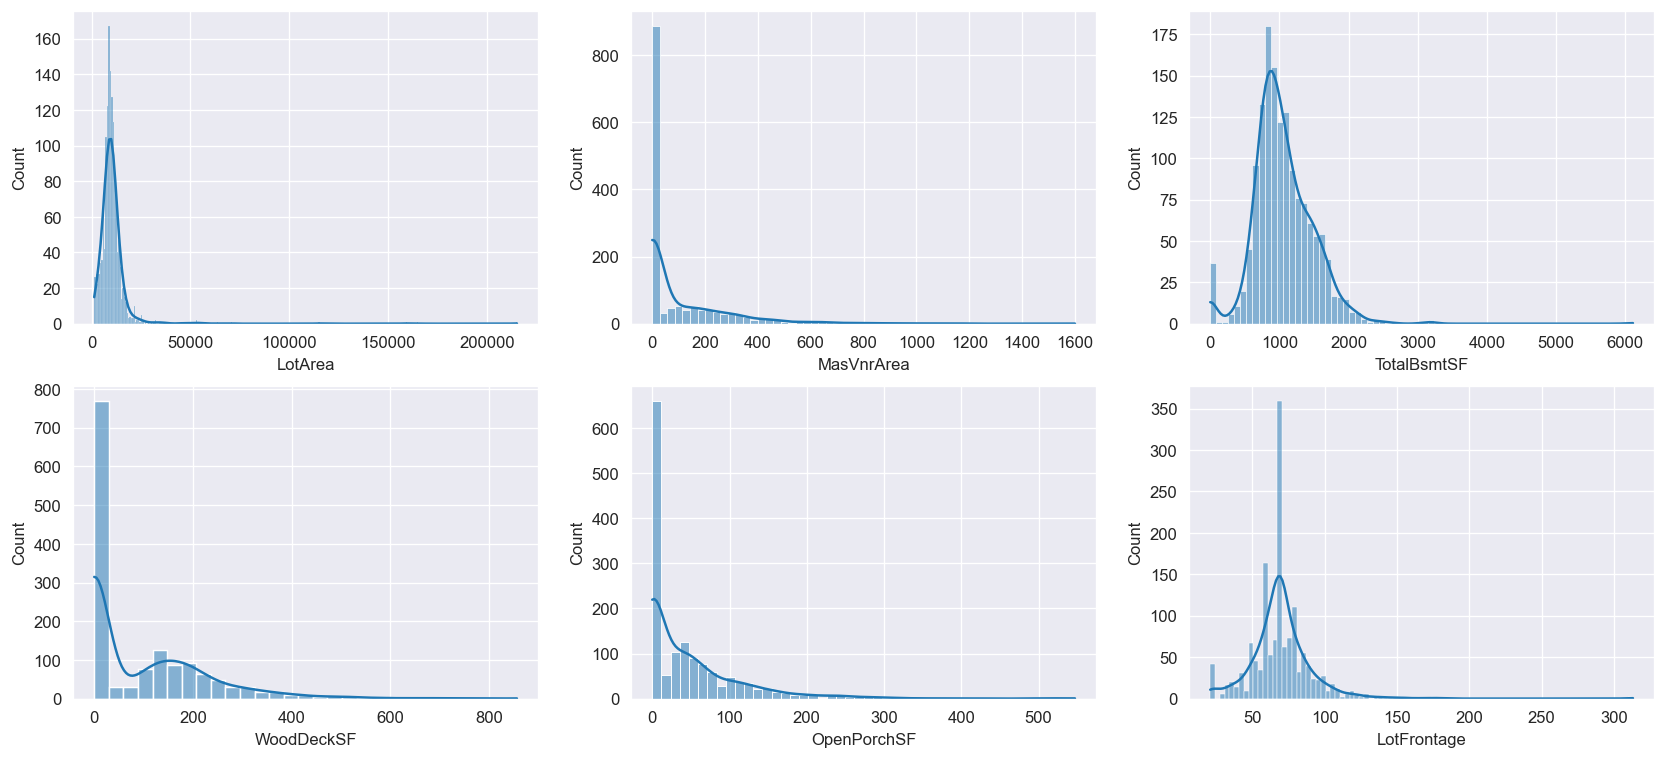

In [42]:
plt.figure(figsize=(17, 20), dpi=120)
plt.subplot(5,3,1)
sns.histplot(data['LotArea'],  kde=True)
plt.subplot(5,3,2)
sns.histplot(data['MasVnrArea'],  kde=True)
plt.subplot(5,3,3)
sns.histplot(data['TotalBsmtSF'],  kde=True)
plt.subplot(5,3,4)
sns.histplot(data['WoodDeckSF'],  kde=True)
plt.subplot(5,3,5)
sns.histplot(data['OpenPorchSF'],  kde=True)
plt.subplot(5,3,6)
sns.histplot(data['LotFrontage'],  kde=True)
plt.show()

#### We can clearly see that there are outliers present in the data we now need to remove these for our algoritm to fit  

In [43]:
# Removing Outliers

# Removing values beyond 98% for LotArea

nn_quartile_LotArea = data['LotArea'].quantile(0.98)
data = data[data["LotArea"] < nn_quartile_LotArea]

# Removing values beyond 98% for MasVnrArea

nn_quartile_MasVnrArea = data['MasVnrArea'].quantile(0.98)
data = data[data["MasVnrArea"] < nn_quartile_MasVnrArea]

# Removing values beyond 99% for TotalBsmtSF

nn_quartile_TotalBsmtSF = data['TotalBsmtSF'].quantile(0.99)
data = data[data["TotalBsmtSF"] < nn_quartile_TotalBsmtSF]

# Removing values beyond 99% for WoodDeckSF

nn_quartile_WoodDeckSF = data['WoodDeckSF'].quantile(0.99)
data = data[data["WoodDeckSF"] < nn_quartile_WoodDeckSF]

# Removing values beyond 99% for OpenPorchSF

nn_quartile_OpenPorchSF = data['OpenPorchSF'].quantile(0.99)
data = data[data["OpenPorchSF"] < nn_quartile_OpenPorchSF]

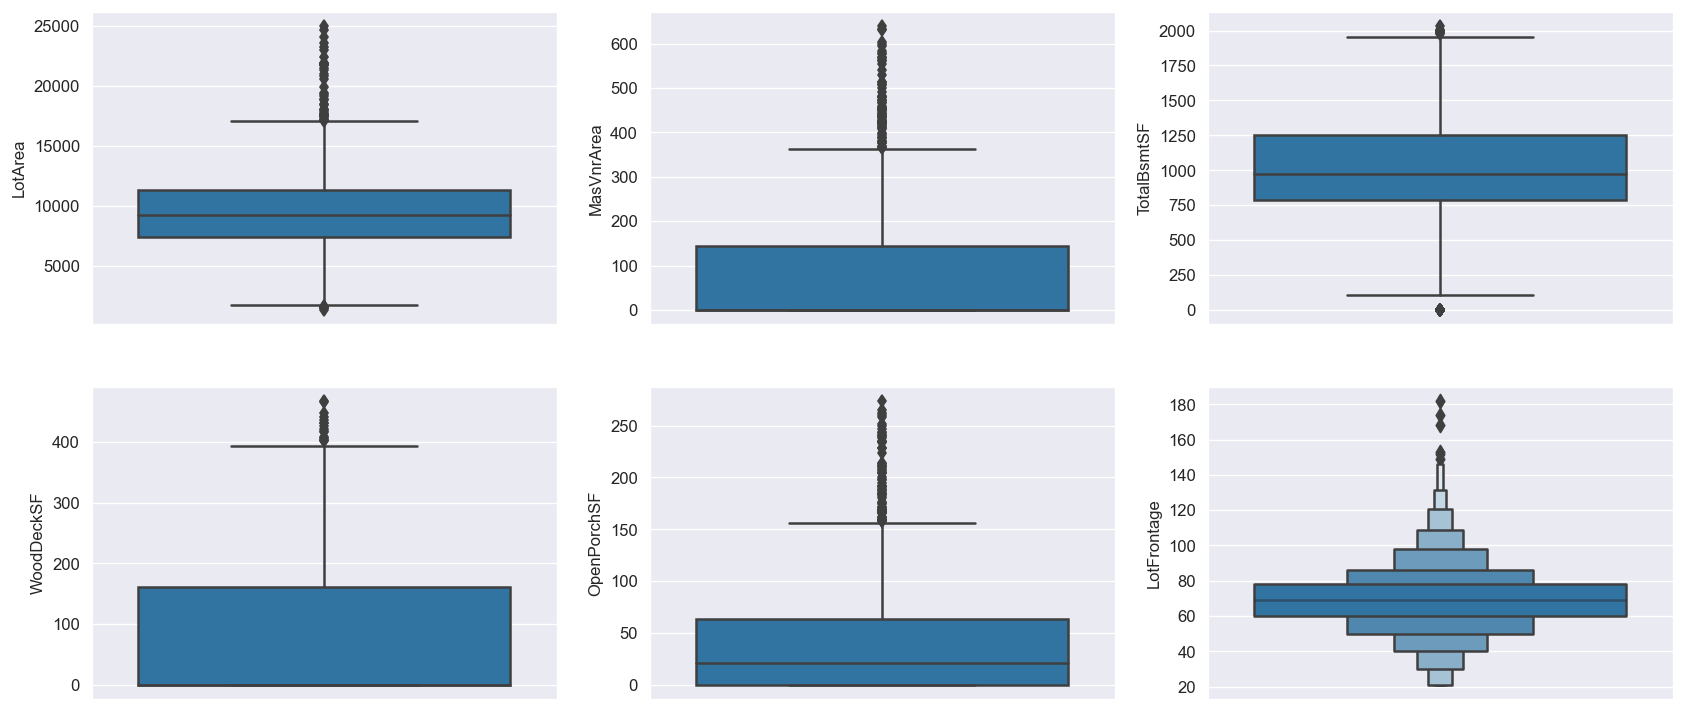

In [44]:
plt.figure(figsize=(17, 20), dpi=120)
plt.subplot(5,3,1)
sns.boxplot(y = 'LotArea', data=data )
plt.subplot(5,3,2)
sns.boxplot(y = 'MasVnrArea', data=data )
plt.subplot(5,3,3)
sns.boxplot(y = 'TotalBsmtSF', data=data)
plt.subplot(5,3,4)
sns.boxplot(y = 'WoodDeckSF', data=data )
plt.subplot(5,3,5)
sns.boxplot(y = 'OpenPorchSF', data=data)
plt.subplot(5,3,6)
sns.boxenplot(y='LotFrontage', data=data)
plt.show()

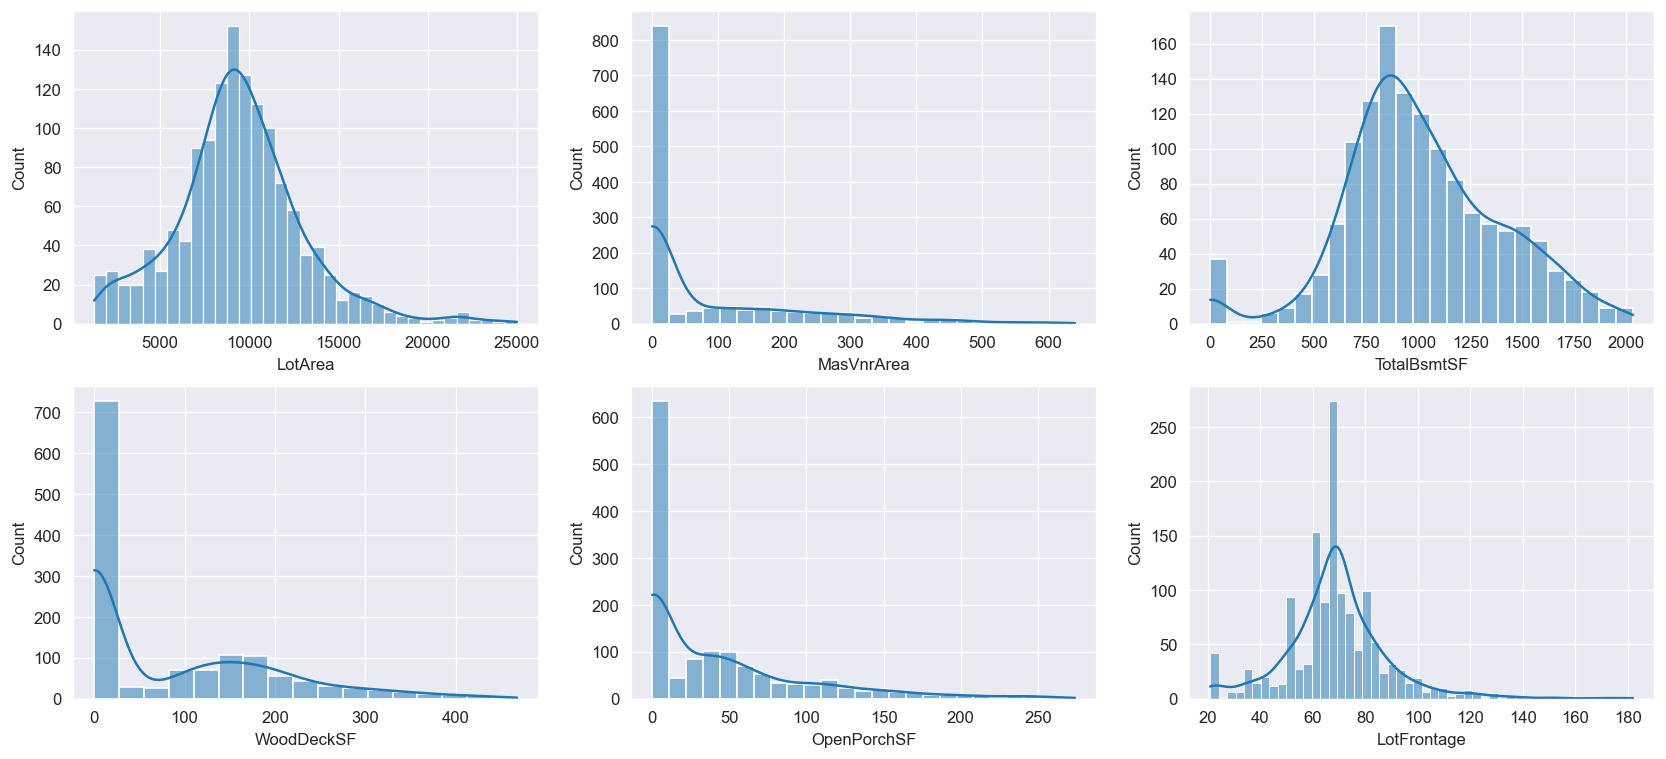

In [45]:
plt.figure(figsize=(17, 20), dpi=120)
plt.subplot(5,3,1)
sns.histplot(data['LotArea'],  kde=True)
plt.subplot(5,3,2)
sns.histplot(data['MasVnrArea'],  kde=True)
plt.subplot(5,3,3)
sns.histplot(data['TotalBsmtSF'],  kde=True)
plt.subplot(5,3,4)
sns.histplot(data['WoodDeckSF'],  kde=True)
plt.subplot(5,3,5)
sns.histplot(data['OpenPorchSF'],  kde=True)
plt.subplot(5,3,6)
sns.histplot(data['LotFrontage'],  kde=True)
plt.show()

### We can cleary see that even after processing the data not all atributes are normally distributed, we shall handel them later in the analysis 

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

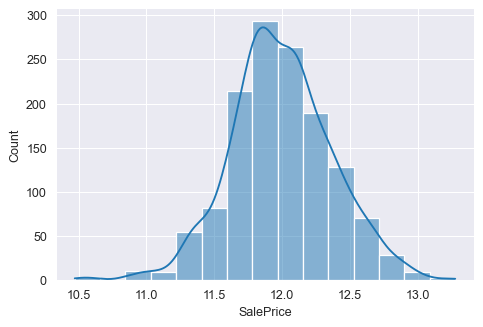

In [46]:
# visulizing the SalesPrice
plt.figure(dpi=90)
sns.histplot(np.log1p(data['SalePrice']), kde=True, bins=15)

In [47]:
# convering the price into natural log 
data['SalePrice']=np.log1p(data['SalePrice'])

### Plotting Box plots to see the relationship between different variables and sale price

<Figure size 540x360 with 0 Axes>

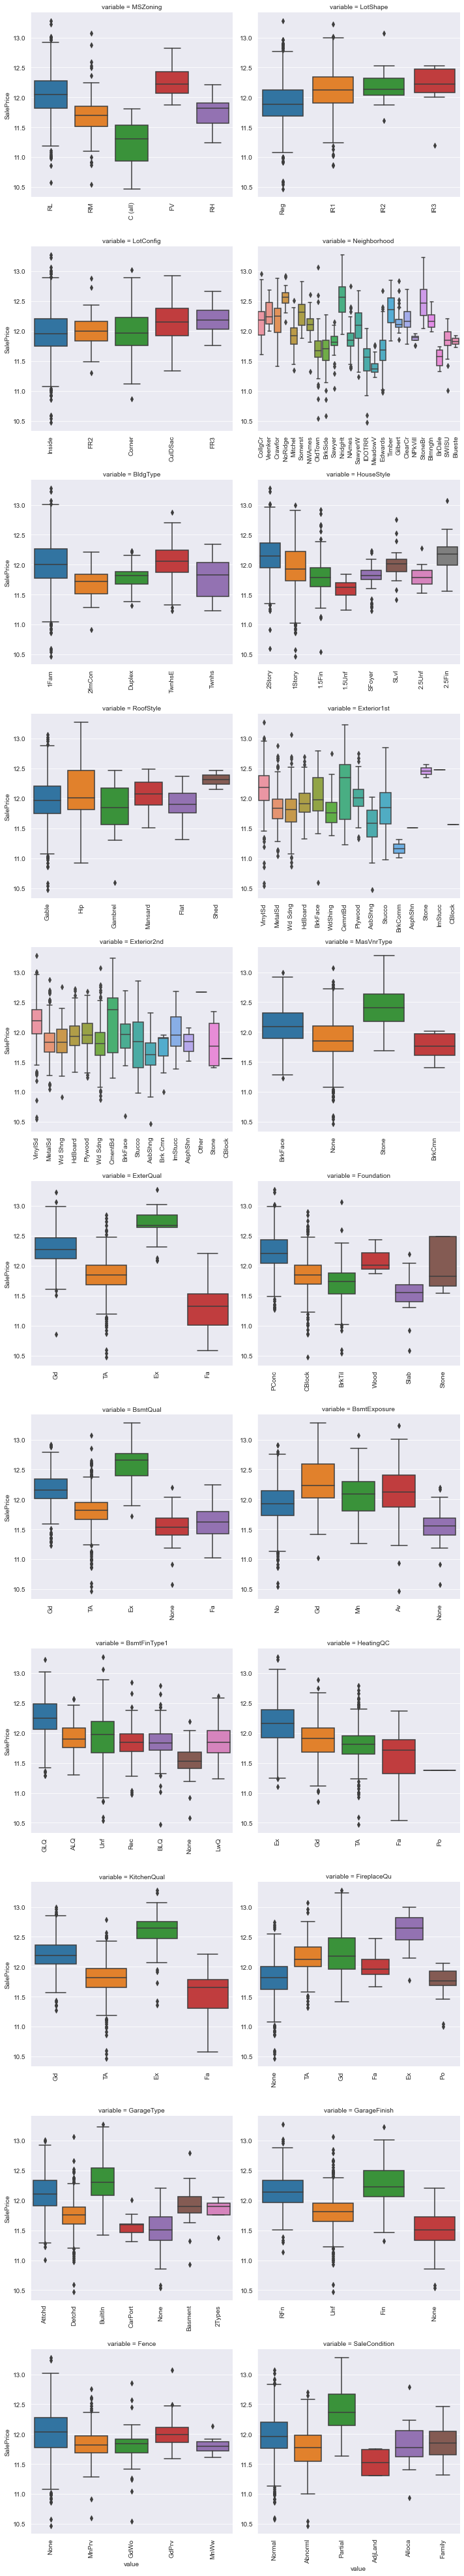

In [48]:
qualitative = [f for f in data.columns if data.dtypes[f] == 'object']
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(data, id_vars=['SalePrice'], value_vars=qualitative)
plt.figure(dpi=90)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(boxplot, "value", "SalePrice")

#### We cam see that there isn't any trend here

<AxesSubplot:>

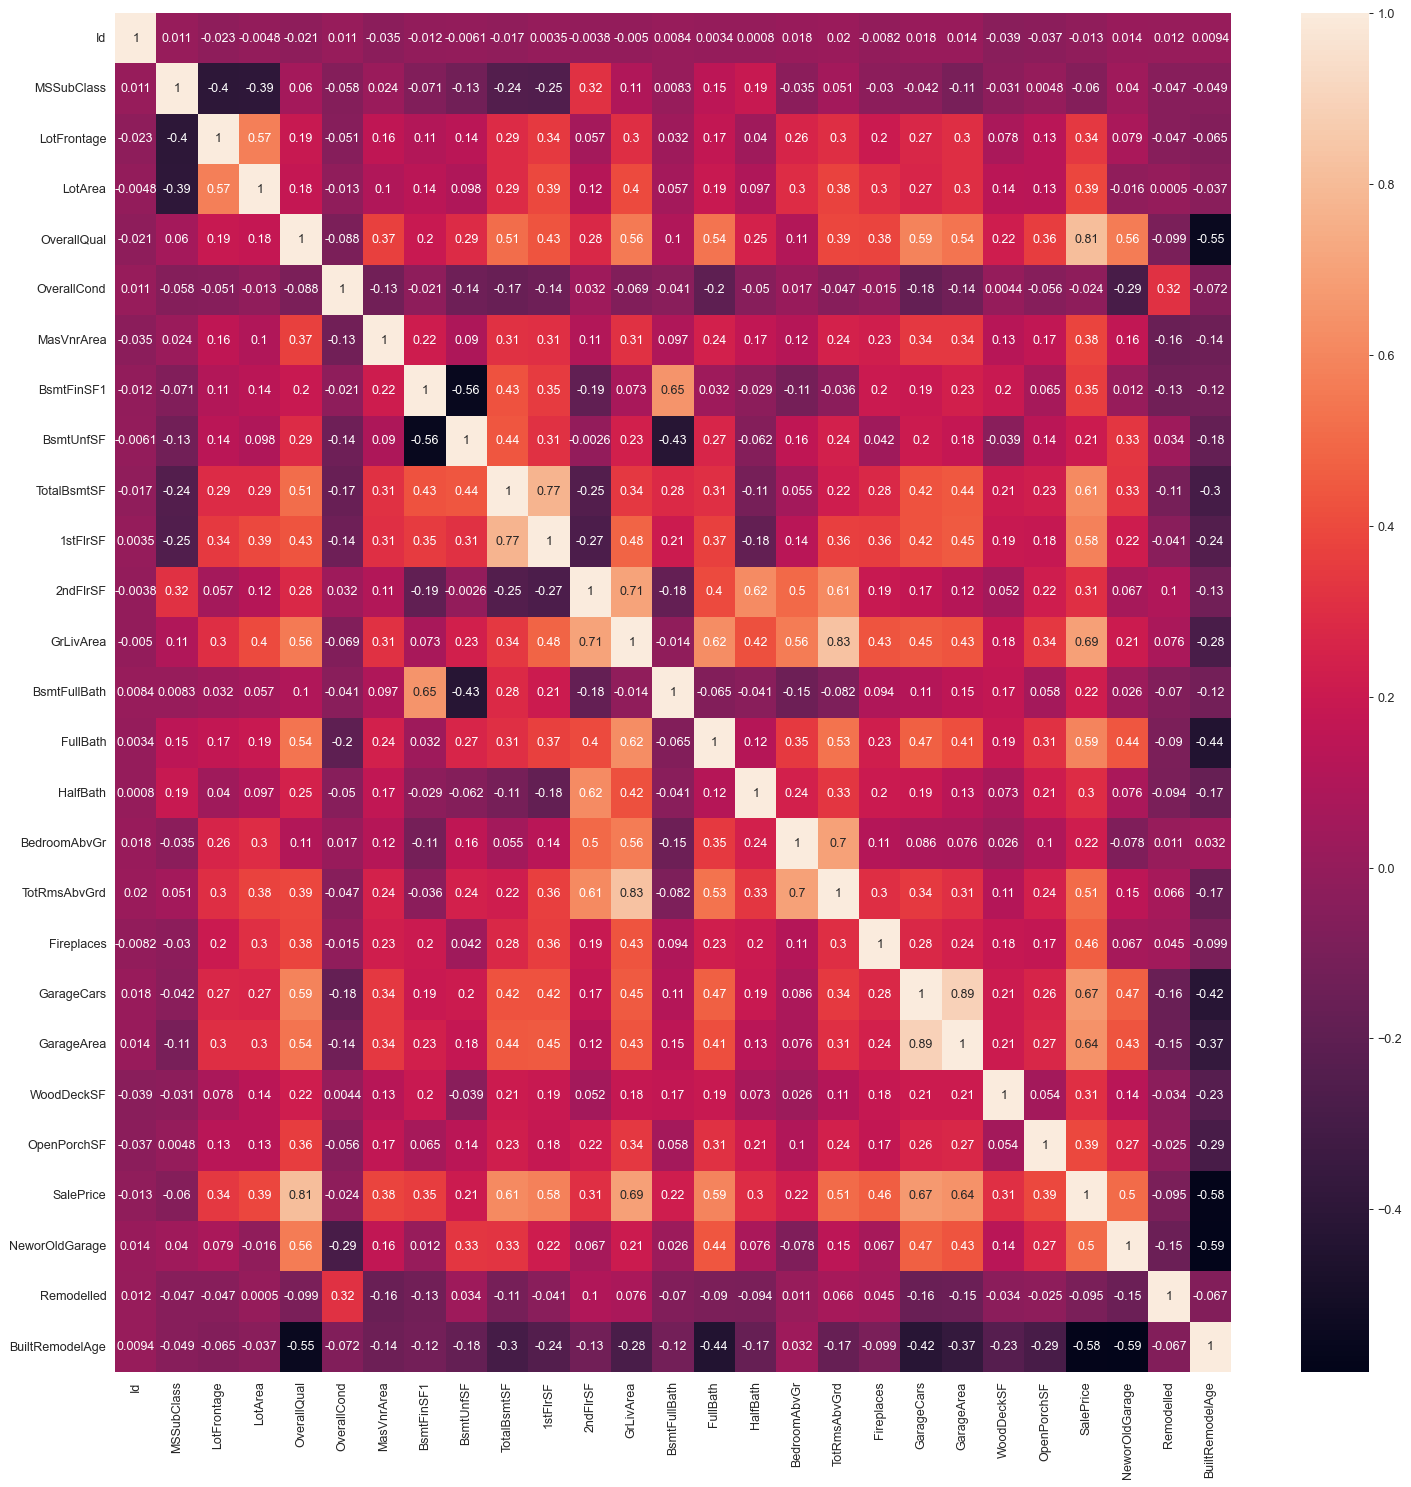

In [49]:
plt.figure(figsize=[20,20], dpi=90)
sns.heatmap(data.corr(), annot=True)

#### We can clearly see that Garage Area and Garage Cars show .89 and TotRmsAbvGrd and GrLivArea show .83 correlation 

In [50]:
data.drop(['TotRmsAbvGrd', 'GarageArea'], axis = 1, inplace = True)

In [51]:
# sns.pairplot(data)

# DATA TRANSFORMATION 

In [52]:
data['d_LotShape'] = data['LotShape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0})
data['d_ExterQual'] = data['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })
data['d_BsmtQual'] = data['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
data['d_BsmtExposure'] = data['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
data['d_BsmtFinType1'] = data['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 
                                                                 'None': 0})
data['d_HeatingQC'] = data['HeatingQC'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
data['d_KitchenQual'] = data['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
data['d_FireplaceQu'] = data['FireplaceQu'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
data['d_GarageFinish'] = data['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0 })
data['d_BldgType'] = data['BldgType'].map({'Twnhs': 5, 'TwnhsE': 4, 'Duplex': 3, '2fmCon': 2, '1Fam': 1, 
                                                                 'None': 0 })
data['d_HouseStyle'] = data['HouseStyle'].map({'SLvl': 8, 'SFoyer': 7, '2.5Fin': 6, '2.5Unf': 5, '2Story': 4, 
                                                                 '1.5Fin': 3, '1.5Unf': 2, '1Story': 1, 'None': 0 })
data['d_Fence'] = data['Fence'].map({'GdPrv': 4, 'GdWo': 3, 'MnPrv': 2, 'MnWw': 1, 'None': 0 })
data['d_LotConfig'] = data['LotConfig'].map({'Inside': 5, 'Corner': 4, 'CulDSac': 3, 'FR2': 2, 'FR3': 1, 
                                                           'None': 0  })
data['d_MasVnrType'] = data['MasVnrType'].map({'BrkCmn': 1, 'BrkFace': 1, 'CBlock': 1, 'Stone': 1, 'None': 0 })
data['d_SaleCondition'] = data['SaleCondition'].map({'Normal': 1, 'Partial': 1, 'Abnorml': 0, 'Family': 0, 
                                                                   'Alloca': 0, 'AdjLand': 0, 'None': 0})
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,WoodDeckSF,OpenPorchSF,Fence,SaleCondition,SalePrice,NeworOldGarage,Remodelled,BuiltRemodelAge,d_LotShape,d_ExterQual,d_BsmtQual,d_BsmtExposure,d_BsmtFinType1,d_HeatingQC,d_KitchenQual,d_FireplaceQu,d_GarageFinish,d_BldgType,d_HouseStyle,d_Fence,d_LotConfig,d_MasVnrType,d_SaleCondition
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,150,856,Ex,856,854,1710,1,2,1,3,Gd,0,None,Attchd,RFn,2,0,61,None,Normal,12.247699,1,0,5,3,4,4,1,6,5,4,0,2,1,4,0,5,1,1
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,284,1262,Ex,1262,0,1262,0,2,0,3,TA,1,TA,Attchd,RFn,2,298,0,None,Normal,12.109016,0,0,31,3,3,4,4,5,5,3,3,2,1,1,0,2,0,1
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,434,920,Ex,920,866,1786,1,2,1,3,Gd,1,TA,Attchd,RFn,2,0,42,None,Normal,12.317171,1,1,6,2,4,4,2,6,5,4,3,2,1,4,0,5,1,1
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,540,756,Gd,961,756,1717,1,1,0,3,Gd,1,Gd,Detchd,Unf,3,0,35,None,Abnorml,11.849405,0,1,36,2,3,3,1,5,4,4,4,1,1,4,0,4,0,0
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,490,1145,Ex,1145,1053,2198,1,2,1,4,Gd,1,TA,Attchd,RFn,3,192,84,None,Normal,12.429220,1,0,8,2,4,4,3,6,5,4,3,2,1,4,0,2,1,1


### We have create numrical values for the categorical variables and now we will drop these as we have extracted information out of them

In [53]:
data = data.drop(['Id', 'LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 
                                'KitchenQual', 'FireplaceQu', 'GarageFinish', 'BldgType', 'HouseStyle', 'Fence', 
                                'LotConfig', 'MasVnrType', 'SaleCondition'], axis=1)

In [54]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrArea,Foundation,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageType,GarageCars,WoodDeckSF,OpenPorchSF,SalePrice,NeworOldGarage,Remodelled,BuiltRemodelAge,d_LotShape,d_ExterQual,d_BsmtQual,d_BsmtExposure,d_BsmtFinType1,d_HeatingQC,d_KitchenQual,d_FireplaceQu,d_GarageFinish,d_BldgType,d_HouseStyle,d_Fence,d_LotConfig,d_MasVnrType,d_SaleCondition
0,60,RL,65.0,8450,CollgCr,7,5,Gable,VinylSd,VinylSd,196.0,PConc,706,150,856,856,854,1710,1,2,1,3,0,Attchd,2,0,61,12.247699,1,0,5,3,4,4,1,6,5,4,0,2,1,4,0,5,1,1
1,20,RL,80.0,9600,Veenker,6,8,Gable,MetalSd,MetalSd,0.0,CBlock,978,284,1262,1262,0,1262,0,2,0,3,1,Attchd,2,298,0,12.109016,0,0,31,3,3,4,4,5,5,3,3,2,1,1,0,2,0,1
2,60,RL,68.0,11250,CollgCr,7,5,Gable,VinylSd,VinylSd,162.0,PConc,486,434,920,920,866,1786,1,2,1,3,1,Attchd,2,0,42,12.317171,1,1,6,2,4,4,2,6,5,4,3,2,1,4,0,5,1,1
3,70,RL,60.0,9550,Crawfor,7,5,Gable,Wd Sdng,Wd Shng,0.0,BrkTil,216,540,756,961,756,1717,1,1,0,3,1,Detchd,3,0,35,11.849405,0,1,36,2,3,3,1,5,4,4,4,1,1,4,0,4,0,0
4,60,RL,84.0,14260,NoRidge,8,5,Gable,VinylSd,VinylSd,350.0,PConc,655,490,1145,1145,1053,2198,1,2,1,4,1,Attchd,3,192,84,12.429220,1,0,8,2,4,4,3,6,5,4,3,2,1,4,0,2,1,1


#### Now we will create dummy variables for the categorical variables 

In [55]:
# Creating dummies for MSZoning

d_MSZoning = pd.get_dummies(data['MSZoning'], prefix='MSZoning', drop_first = True)


# Creating dummies for GarageType

d_GarageType = pd.get_dummies(data['GarageType'], prefix='GarageType', drop_first = True)

# Creating dummies for Neighborhood

d_Neighborhood = pd.get_dummies(data['Neighborhood'], prefix='Neighborhood', drop_first = True)

# Creating dummies for RoofStyle

d_RoofStyle = pd.get_dummies(data['RoofStyle'], prefix='RoofStyle', drop_first = True)


# Creating dummies for Exterior1st

d_Exterior1st = pd.get_dummies(data['Exterior1st'], prefix='Exterior1st', drop_first = True)


# Creating dummies for Exterior2nd

d_Exterior2nd = pd.get_dummies(data['Exterior2nd'], prefix='Exterior2nd', drop_first = True)


# Creating dummies for Foundation

d_Foundation = pd.get_dummies(data['Foundation'], prefix='Foundation', drop_first = True)

# Appending these dummy varibles to the main dataframe

data = pd.concat([data, d_MSZoning, d_Neighborhood, d_RoofStyle, d_Exterior1st, d_Exterior2nd, d_Foundation, d_GarageType], axis = 1)



In [56]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrArea,Foundation,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageType,GarageCars,WoodDeckSF,OpenPorchSF,SalePrice,NeworOldGarage,Remodelled,BuiltRemodelAge,d_LotShape,d_ExterQual,d_BsmtQual,d_BsmtExposure,d_BsmtFinType1,d_HeatingQC,d_KitchenQual,d_FireplaceQu,d_GarageFinish,d_BldgType,d_HouseStyle,d_Fence,d_LotConfig,d_MasVnrType,d_SaleCondition,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,60,RL,65.0,8450,CollgCr,7,5,Gable,VinylSd,VinylSd,196.0,PConc,706,150,856,856,854,1710,1,2,1,3,0,Attchd,2,0,61,12.247699,1,0,5,3,4,4,1,6,5,4,0,2,1,4,0,5,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
1,20,RL,80.0,9600,Veenker,6,8,Gable,MetalSd,MetalSd,0.0,CBlock,978,284,1262,1262,0,1262,0,2,0,3,1,Attchd,2,298,0,12.109016,0,0,31,3,3,4,4,5,5,3,3,2,1,1,0,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,60,RL,68.0,11250,CollgCr,7,5,Gable,VinylSd,VinylSd,162.0,PConc,486,434,920,920,866,1786,1,2,1,3,1,Attchd,2,0,42,12.317171,1,1,6,2,4,4,2,6,5,4,3,2,1,4,0,5,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
3,70,RL,60.0,9550,Crawfor,7,5,Gable,Wd Sdng,Wd Shng,0.0,BrkTil,216,540,756,961,756,1717,1,1,0,3,1,Detchd,3,0,35,11.849405,0,1,36,2,3,3,1,5,4,4,4,1,1,4,0,4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,60,RL,84.0,14260,NoRidge,8,5,Gable,VinylSd,VinylSd,350.0,PConc,655,490,1145,1145,1053,2198,1,2,1,4,1,Attchd,3,192,84,12.429220,1,0,8,2,4,4,3,6,5,4,3,2,1,4,0,2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0


#### Now that we have extracted these columns we can safely drop the coulumns from which they were initially extracted

In [57]:
data = data.drop(['MSZoning', 'Neighborhood', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 
                                'GarageType'], axis=1)

In [58]:
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,SalePrice,NeworOldGarage,Remodelled,BuiltRemodelAge,d_LotShape,d_ExterQual,d_BsmtQual,d_BsmtExposure,d_BsmtFinType1,d_HeatingQC,d_KitchenQual,d_FireplaceQu,d_GarageFinish,d_BldgType,d_HouseStyle,d_Fence,d_LotConfig,d_MasVnrType,d_SaleCondition,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,60,65.0,8450,7,5,196.0,706,150,856,856,854,1710,1,2,1,3,0,2,0,61,12.247699,1,0,5,3,4,4,1,6,5,4,0,2,1,4,0,5,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
1,20,80.0,9600,6,8,0.0,978,284,1262,1262,0,1262,0,2,0,3,1,2,298,0,12.109016,0,0,31,3,3,4,4,5,5,3,3,2,1,1,0,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,60,68.0,11250,7,5,162.0,486,434,920,920,866,1786,1,2,1,3,1,2,0,42,12.317171,1,1,6,2,4,4,2,6,5,4,3,2,1,4,0,5,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
3,70,60.0,9550,7,5,0.0,216,540,756,961,756,1717,1,1,0,3,1,3,0,35,11.849405,0,1,36,2,3,3,1,5,4,4,4,1,1,4,0,4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,60,84.0,14260,8,5,350.0,655,490,1145,1145,1053,2198,1,2,1,4,1,3,192,84,12.429220,1,0,8,2,4,4,3,6,5,4,3,2,1,4,0,2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1358 entries, 0 to 1458
Columns: 112 entries, MSSubClass to GarageType_None
dtypes: float64(3), int64(36), uint8(73)
memory usage: 521.2 KB


In [60]:
detailed_new,_,_ = detailed(data)

C:\Users\samee\AppData\Local\Temp\ipykernel_5564\4081806815.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ddata[cols] = [size,nul_val,dtype,rng]
C:\Users\samee\AppData\Local\Temp\ipykernel_5564\4081806815.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ddata[cols] = [size,nul_val,dtype,rng]
C:\Users\samee\AppData\Local\Temp\ipykernel_5564\4081806815.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

In [61]:
detailed_new

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,SalePrice,NeworOldGarage,Remodelled,BuiltRemodelAge,d_LotShape,d_ExterQual,d_BsmtQual,d_BsmtExposure,d_BsmtFinType1,d_HeatingQC,d_KitchenQual,d_FireplaceQu,d_GarageFinish,d_BldgType,d_HouseStyle,d_Fence,d_LotConfig,d_MasVnrType,d_SaleCondition,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
total,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358,1358
% missing,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358,0.0% - 0/1358
data Typ

### We can now clearly see that the all the columns have been converted into numerical form

## CONVERTING DATA IN TRAIN TEST 

In [62]:
X = data.drop(['SalePrice'], axis=1)

In [63]:
y = data.SalePrice

In [64]:
y

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1454    12.128117
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
Name: SalePrice, Length: 1358, dtype: float64

### Scaling Features 

In [65]:
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone',
       'Foundation_Wood', 'GarageType_Attchd', 'GarageType_Basment',
       'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd',
       'GarageType_None'],
      dtype='object', length=111)

In [66]:
np.random.seed(111)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=42)

### Feature Selection and elimination 

In [67]:
LR = LinearRegression()

In [68]:
LR.fit(X_train, y_train)

LinearRegression()

In [69]:
rfe = RFE(LR)

In [70]:
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression())

In [71]:
cols_selected = X_train.columns[rfe.support_]

In [72]:
temp_df = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)), columns=['Variable', 'rfe_support', 'rfe_ranking'])
temp_df = temp_df.loc[temp_df['rfe_support'] == True]
temp_df.reset_index(drop=True, inplace=True)

In [73]:
temp_df

,Variable,rfe_support,rfe_ranking
0,LotArea,True,1
1,OverallQual,True,1
2,OverallCond,True,1
3,BsmtFinSF1,True,1
4,TotalBsmtSF,True,1
5,2ndFlrSF,True,1
6,GrLivArea,True,1
7,BsmtFullBath,True,1
8,FullBath,True,1
9,HalfBath,True,1


#### Selecting the only columns which are useful for the analysis 

In [74]:
X_train=X_train[cols_selected]

In [75]:
X_test = X_test[cols_selected]

# MODEL BUILDING 

### RIDGE 

In [76]:
# list pf alphas

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# Tuning to find the best alpha

folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [77]:
ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=500]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
0,0.0001,-0.078737,-0.085193,1
1,0.001,-0.078737,-0.085193,2
2,0.01,-0.078737,-0.085193,3
3,0.1,-0.078738,-0.085194,4
4,0.2,-0.078739,-0.085195,5
5,0.3,-0.078740,-0.085196,6
6,0.4,-0.078741,-0.085197,7
7,0.5,-0.078742,-0.085198,8
8,0.6,-0.078743,-0.085199,9
9,0.7,-0.078744,-0.085200,10


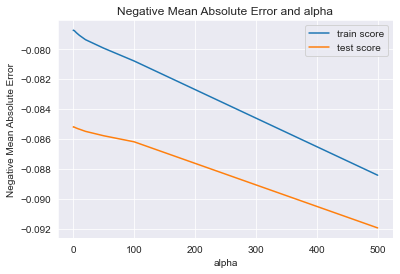

In [78]:
ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int32')

# plotting

plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [79]:
ridge_model_cv.best_estimator_

Ridge(alpha=0.0001)

In [80]:
alpha = 0.0001
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)

Ridge(alpha=0.0001)

In [81]:
ridge.coef_

array([ 3.09275649e-02,  7.41225683e-02,  4.90861183e-02,  3.33477116e-02,
        4.04109627e-02, -1.12814733e-02,  1.12920048e-01,  1.21925384e-02,
        1.25548428e-02,  1.62592519e-02,  3.52779112e-02,  1.61522288e-02,
       -1.52714900e-02, -2.86287126e-02,  1.56860716e-02,  1.11544890e-02,
        2.24966304e-02,  2.23281530e-02,  1.76214810e-02, -2.53104094e-02,
        1.49988553e-02,  7.78503909e-02,  3.45350786e-02,  1.32216595e-01,
        1.05097107e-01,  0.00000000e+00, -1.31564768e-02, -1.99272452e-02,
       -3.11466459e-02, -2.24019215e-02, -1.87958617e-02, -1.67300122e-02,
       -1.55858307e-02, -2.84508986e-02, -1.89613700e-02, -4.46019794e-02,
       -1.35405286e-02, -1.71530530e-02, -1.53181779e-02, -1.32674294e-02,
        9.38314133e-27, -4.69157066e-27, -8.01145455e-04, -1.86941243e-02,
       -1.82282074e-02, -2.80101875e-02, -8.01145450e-04,  2.62974495e-02,
        2.86316044e-02, -4.69157066e-27,  2.21644968e-02,  1.63703551e-02,
        3.13575271e-02,  

In [82]:
mean_squared_error(y_test, ridge.predict(X_test))

0.013302203534092904

In [83]:
r2_score(y_test, ridge.predict(X_test))

0.8955042854315681

In [84]:
# creating df with their coefficient values
ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4), 'absoulte_coefficient':abs(ridge.coef_.round(4))})
ridge_df.reset_index(drop=True, inplace=True)
ridge_df

,Features,Coefficient,absoulte_coefficient
0,LotArea,0.0309,0.0309
1,OverallQual,0.0741,0.0741
2,OverallCond,0.0491,0.0491
3,BsmtFinSF1,0.0333,0.0333
4,TotalBsmtSF,0.0404,0.0404
5,2ndFlrSF,-0.0113,0.0113
6,GrLivArea,0.1129,0.1129
7,BsmtFullBath,0.0122,0.0122
8,FullBath,0.0126,0.0126
9,HalfBath,0.0163,0.0163


<AxesSubplot:xlabel='Coefficient', ylabel='Features'>

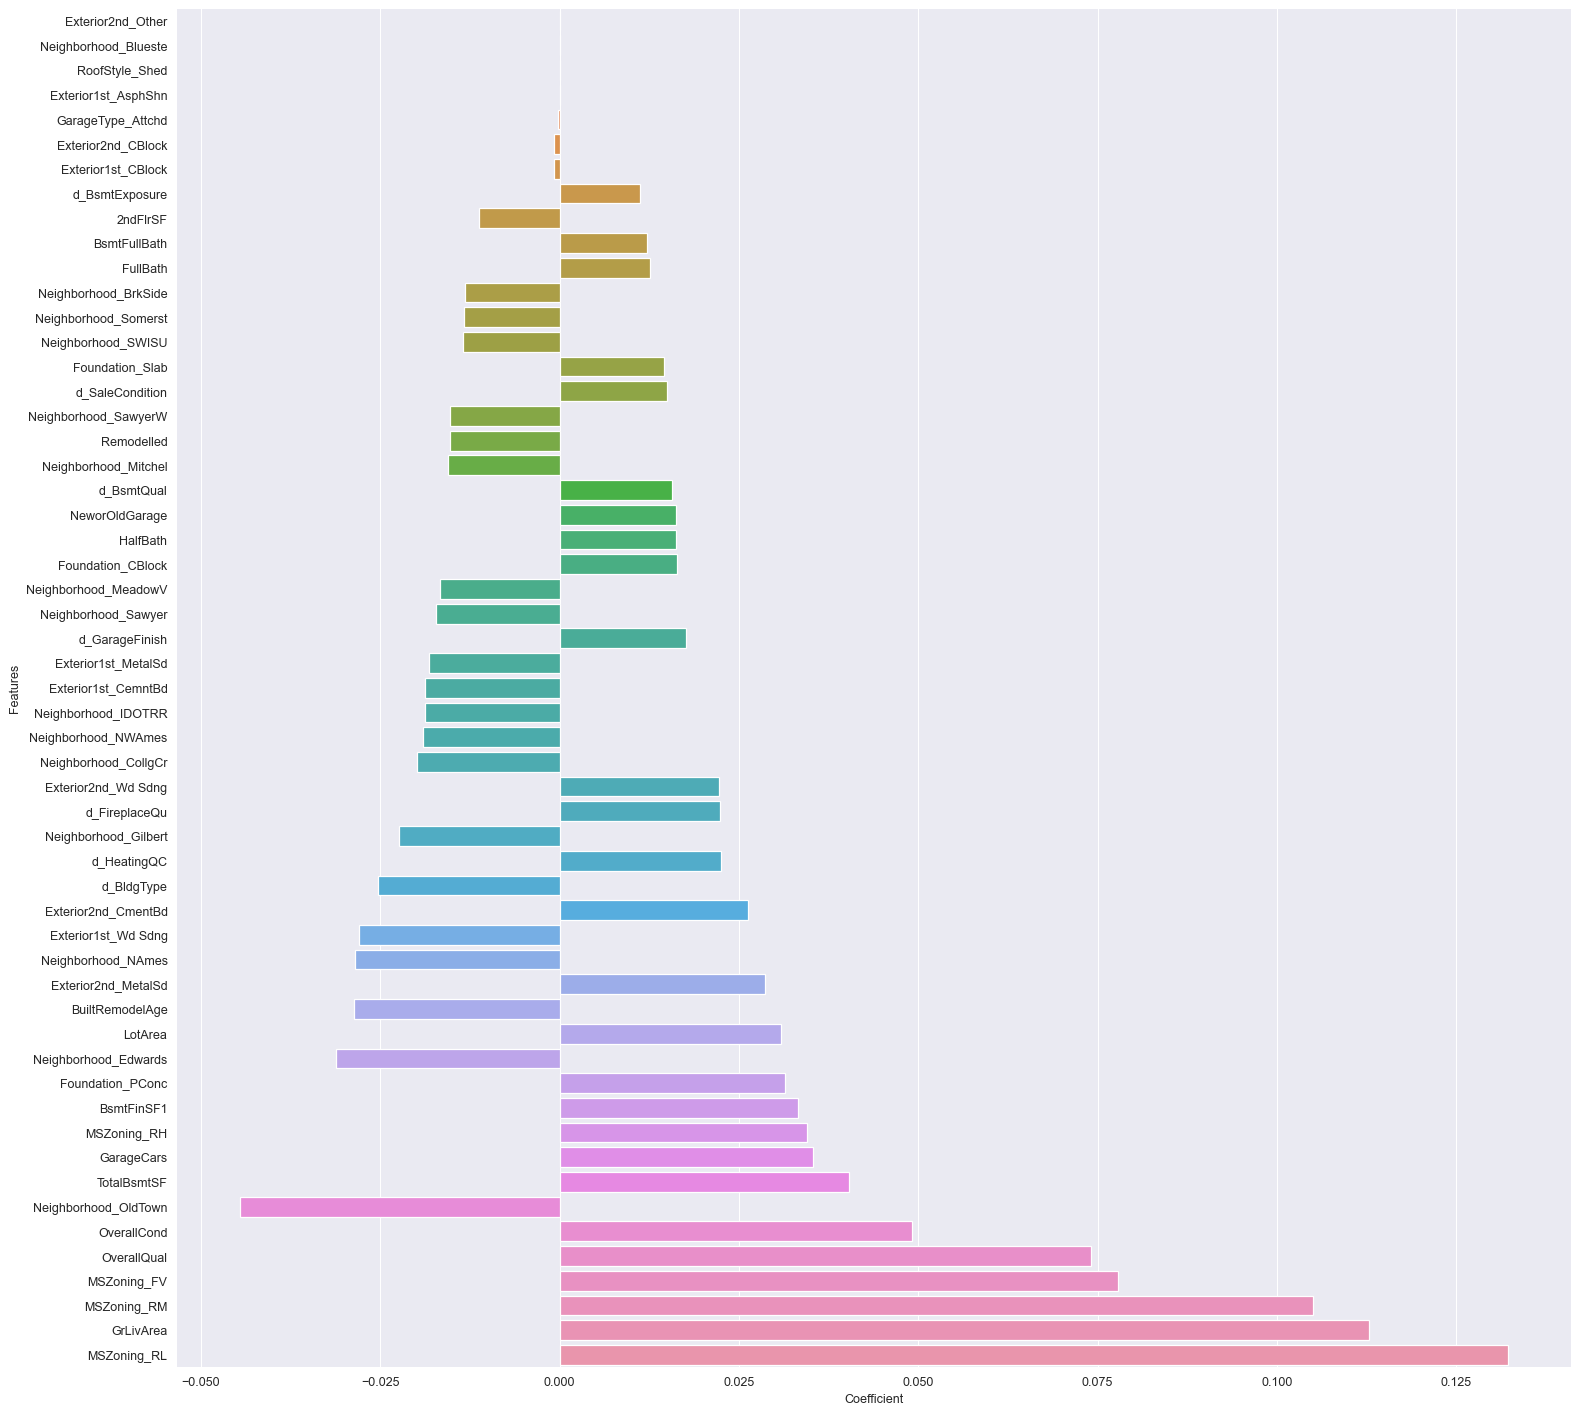

In [85]:
# Plotting coeffiecients
plt.figure(figsize=[20,20], dpi=90)
sns.barplot(y='Features', x='Coefficient', data=ridge_df.sort_values(by=['absoulte_coefficient']))

### PLOTTING LOSS 

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

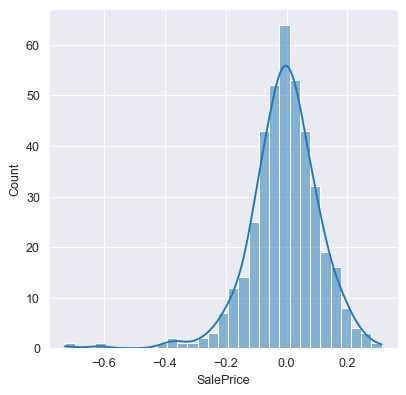

In [86]:
#  checking for error distribution
plt.figure(figsize=[5,5], dpi=90)
sns.histplot(y_test-ridge.predict(X_test), kde=True)

C:\Users\samee\.conda\envs\upg\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SalePrice', ylabel='SalePrice'>

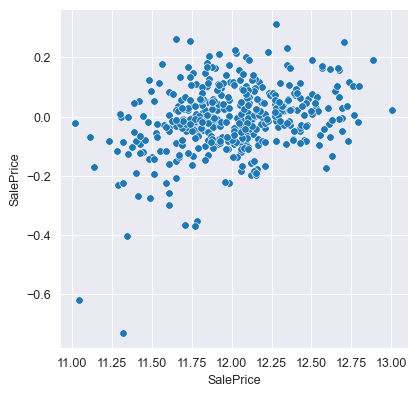

In [87]:
# checking for baising
plt.figure(figsize=[5,5], dpi=90)
sns.scatterplot(y_test,y_test-ridge.predict(X_test))

#### From the residual we can see that it follows a normal distribution as well and there is no baising in the residuals

#### We have the optimal alpha value and cofficient values for Ridge  

## Lasso 

In [89]:
lasso = Lasso()

# list of alphas

params = {'alpha': [0.0001, 0.001, 0.0002, 0.0003, 0.0004,
                    0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0]}

# cross validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.0002, 0.0003, 0.0004,
                                   0.0005, 0.001, 0.002, 0.003, 0.004, 0.005,
                                   0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                   0.7, 0.8, 0.9, 1.0, 2.0, 3.0]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [90]:
lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
0,0.0001,-0.078787,-0.085264,1
2,0.0002,-0.078868,-0.085364,2
3,0.0003,-0.078969,-0.085476,3
4,0.0004,-0.079094,-0.085547,4
5,0.0005,-0.079197,-0.085622,5
1,0.001,-0.079850,-0.086085,6
6,0.001,-0.079850,-0.086085,6
7,0.002,-0.081347,-0.086936,8
8,0.003,-0.082110,-0.087255,9
9,0.004,-0.082670,-0.087343,10


In [91]:
lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

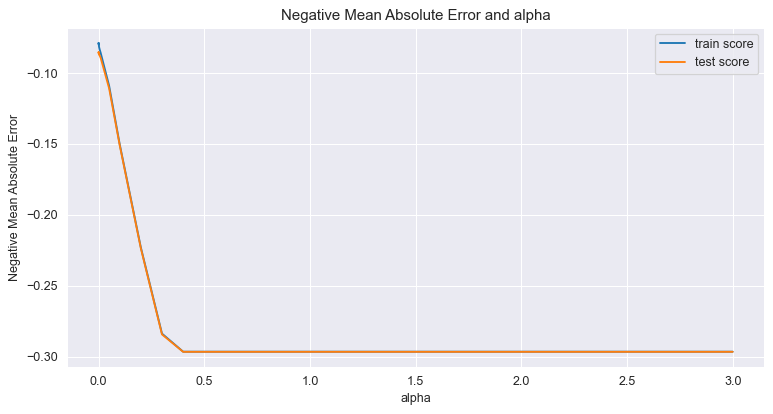

In [92]:
# plotting training graph
plt.figure(figsize=[10,5], dpi=90)
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [93]:
lasso_model_cv.best_estimator_

Lasso(alpha=0.0001)

#### WE can see that 0.0001 is the best alpha value 

In [94]:
# Training the lasso model
alpha = 0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 
lasso.coef_

array([ 0.03083799,  0.07484766,  0.04905216,  0.03369432,  0.04130025,
       -0.00993272,  0.11190937,  0.0118956 ,  0.01236646,  0.01584675,
        0.03526903,  0.01598928, -0.01499808, -0.02869066,  0.01524046,
        0.01100328,  0.02251567,  0.02249479,  0.01763259, -0.0246395 ,
        0.01508854,  0.07311677,  0.0322177 ,  0.12412109,  0.09792107,
        0.        , -0.0126036 , -0.01900161, -0.03021124, -0.0216466 ,
       -0.01912157, -0.01643248, -0.01506144, -0.02707083, -0.01815733,
       -0.04390837, -0.01301917, -0.01631161, -0.01470386, -0.0121135 ,
        0.        , -0.        , -0.0011545 , -0.01484311, -0.01202969,
       -0.02667966, -0.00038262,  0.02252586,  0.02228279, -0.        ,
        0.02078951,  0.01554902,  0.03075616,  0.01435867,  0.        ])

In [95]:
mean_squared_error(y_test, lasso.predict(X_test))

0.013261954713967732

In [96]:
r2_score(y_test, lasso.predict(X_test))

0.895820460808733

In [97]:
# creating df to capture the coefficients
lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4), 'absoulte_coefficient':abs(lasso.coef_.round(4))})
lasso_df = lasso_df[lasso_df['Coefficient'] != 0.00]
lasso_df.reset_index(drop=True, inplace=True)
lasso_df

,Features,Coefficient,absoulte_coefficient
0,LotArea,0.0308,0.0308
1,OverallQual,0.0748,0.0748
2,OverallCond,0.0491,0.0491
3,BsmtFinSF1,0.0337,0.0337
4,TotalBsmtSF,0.0413,0.0413
5,2ndFlrSF,-0.0099,0.0099
6,GrLivArea,0.1119,0.1119
7,BsmtFullBath,0.0119,0.0119
8,FullBath,0.0124,0.0124
9,HalfBath,0.0158,0.0158


<AxesSubplot:xlabel='Coefficient', ylabel='Features'>

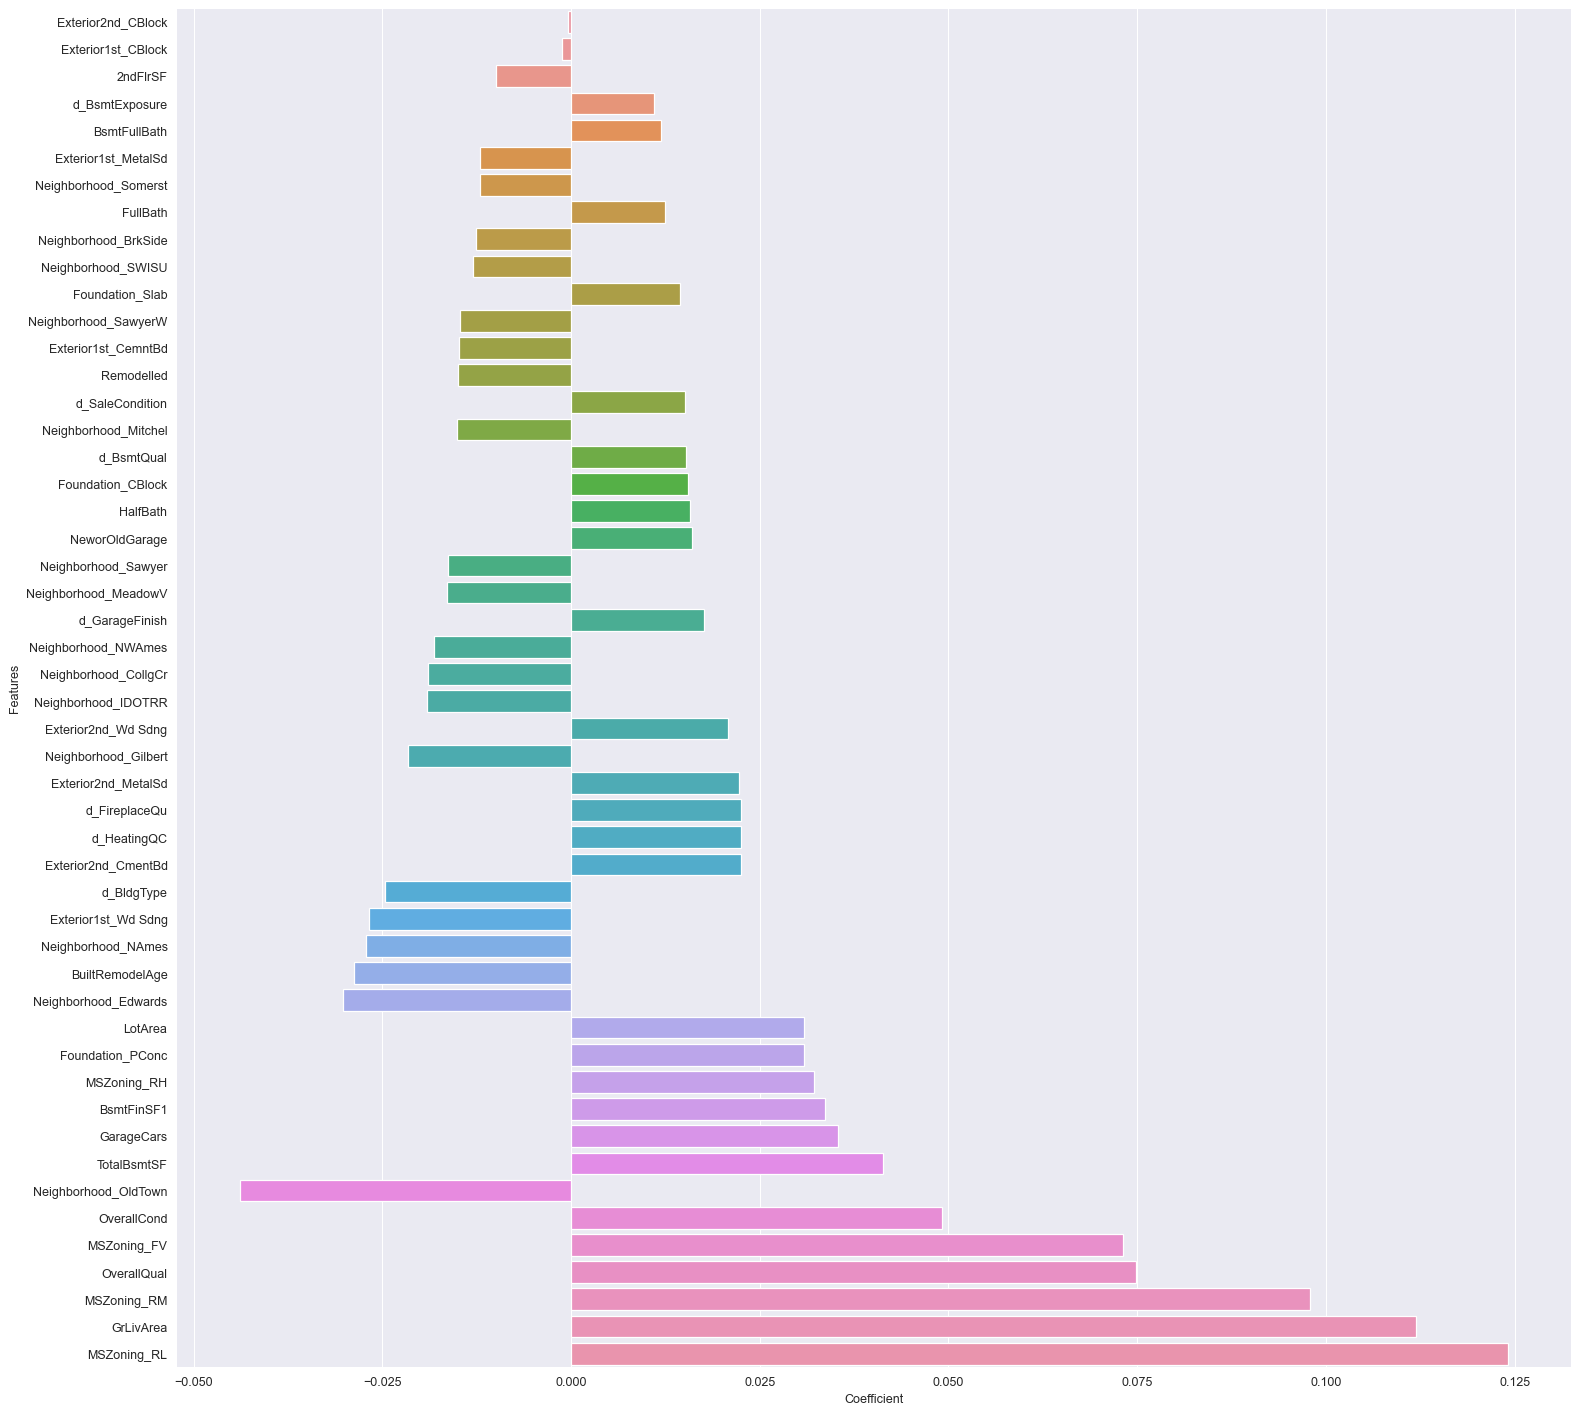

In [98]:
plt.figure(figsize=[20,20], dpi=90)
sns.barplot(y='Features', x='Coefficient', data=lasso_df.sort_values(by=['absoulte_coefficient']))

### PLOTTING LOSS 

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

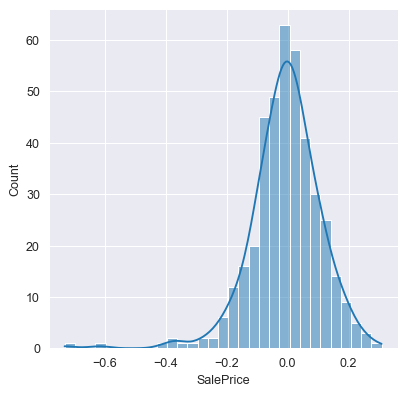

In [99]:
# Checking error distribution
plt.figure(figsize=[5,5], dpi=90)
sns.histplot(y_test-lasso.predict(X_test), kde=True)

#### Checking for homoscedasticity 

C:\Users\samee\.conda\envs\upg\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SalePrice', ylabel='SalePrice'>

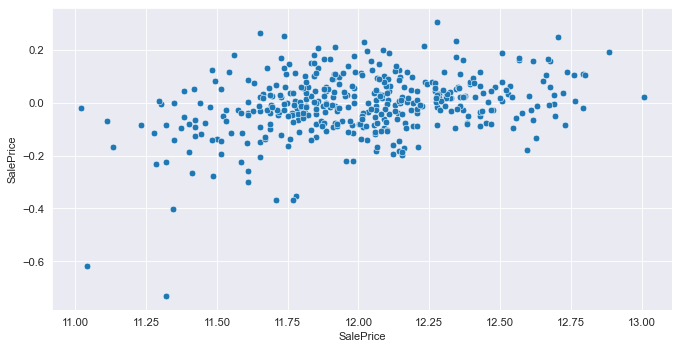

In [100]:
# checking residual distribution
plt.figure(figsize=[10,5], dpi=80)
sns.scatterplot(y_test, y_test-lasso.predict(X_test))

### we can cleary see that the sales residuals are following a normal distribution there is no baising in the residual

<h2>From the above analysis we have the following data:</h2> 
<ul>Alpha for Ridge is :0.0001</ul>
<ul>Alpha for Lasso is :0.0001</ul>
<ul style="color:green">MSE for Lasso is :0.012</ul>
<ul style="color:green">R2 for Lasso is :0.899</ul>
<ul>MSE for Ridge is :0.012</ul>
<ul>R2 for Ridge is :0.899</ul>

#### PRINTING ALL RESULTS 

In [101]:
# model_type : 'Ridge', 'Ridge_double_alpha', 'lasso', 'lasso_double_alpha', 'lasso_except_top_5'
final_values = pd.DataFrame(index=['mse', 'r2'])
final_values['Ridge'] = [mean_squared_error(y_test, ridge.predict(X_test)), r2_score(y_test, ridge.predict(X_test))]
# final_values['Ridge_double_alpha'] = [mean_squared_error(y_test, ridge2.predict(X_test)), r2_score(y_test, ridge2.predict(X_test))]
final_values['lasso'] = [mean_squared_error(y_test, lasso.predict(X_test)), r2_score(y_test, lasso.predict(X_test))]
# final_values['lasso_double_alpha'] = [mean_squared_error(y_test, lasso2.predict(X_test)), r2_score(y_test, lasso2.predict(X_test))]
# final_values['lasso_except_top_5'] = [mean_squared_error(y_test, lasso_not5.predict(X_test_not5)), r2_score(y_test, lasso_not5.predict(X_test_not5))]

In [102]:
final_values

,Ridge,lasso
mse,0.013302,0.013262
r2,0.895504,0.895820


# Conclusion: for the given dataset we can cleary conclude that Lasso is the sighlty better performing model as it also eliminates some features and we are left with the best predictors 